In [1]:
import os
import json
import pprint
import pandas as pd
import seaborn as sns
import pylab as pl
import numpy as np
%matplotlib inline

from pipeline.python.utils import natural_keys, replace_root

from pipeline.python.visualization import plot_psths_from_dataframe as psth
from pipeline.python.traces.utils import load_TID, get_metric_set
from pipeline.python.paradigm.align_acquisition_events import get_stimulus_configs, set_pupil_params


/home/juliana/anaconda/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/juliana/Repositories/2p-pipeline/pipeline/python/visualization/plot_psths_from_dataframe.py:38: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/juliana/anaconda/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/juliana/anaconda/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    e

In [4]:
pp = pprint.PrettyPrinter(indent=4)

# Run info:

rootdir = '/mnt/odyssey'
animalid = 'CE077'
session = '20180321'
acquisition = 'FOV1_zoom1x'
run_list = ['blobs_run3', 'blobs_run4']
traceid_list = ['traces001', 'traces001']

trace_type = 'np_subtracted'

In [16]:
# Pupil filter info:

filter_pupil = True

pupil_radius_min1 = 30
pupil_radius_max1 = 60
pupil_dist_thr1 = 3

pupil_radius_min2 = 30
pupil_radius_max2 = 60
pupil_dist_thr2 = 3

pupilparams = dict((run, dict()) for run in run_list)
for run in run_list:
    pupilparams[run]['radius_min'] = pupil_radius_min1
    pupilparams[run]['radius_max'] = pupil_radius_max1
    pupilparams[run]['dist_thr'] = pupil_dist_thr1

In [17]:
TIDs = {}
#run_dirs = [os.path.join(rootdir, animalid, session, acquisition, run) for run in run_list]
for run, trace_id in zip(run_list, traceid_list):
    run_dir = os.path.join(rootdir, animalid, session, acquisition, run)

    # Load TRACE ID info:
    # =========================================================================
    TID = load_TID(run_dir, trace_id)
    traceid_dir = TID['DST']
    if rootdir not in traceid_dir:
        orig_root = traceid_dir.split('/%s/%s' % (animalid, session))[0]
        traceid_dir = traceid_dir.replace(orig_root, rootdir)
        print "Replacing orig root with dir:", traceid_dir
        TID['DST'] = traceid_dir
    TIDs[run] = TID

USING TRACE ID: traces001
{   u'DST': u'/n/coxfs01/2p-data/CE077/20180321/FOV1_zoom1x/blobs_run3/traces/traces001_5185c1',
    u'PARAMS': {   u'excluded_tiffs': [],
                   u'hashid': u'340136',
                   u'nonnegative': False,
                   u'rid_hash': u'72311a',
                   u'roi_id': u'rois002',
                   u'roi_type': u'manual2D_warp',
                   u'signal_channel': 1,
                   u'tiff_source': u'/n/coxfs01/2p-data/CE077/20180321/FOV1_zoom1x/blobs_run3/processed/processed001_fb8390/mcorrected_57440c',
                   u'uint16': False,
                   u'unsigned': False},
    u'SRC': u'/n/coxfs01/2p-data/CE077/20180321/FOV1_zoom1x/blobs_run3/processed/processed001_fb8390/mcorrected_57440c',
    u'trace_hash': u'5185c1',
    u'trace_id': u'traces001',
    u'version': u'0.1.0'}
Replacing orig root with dir: /mnt/odyssey/CE077/20180321/FOV1_zoom1x/blobs_run3/traces/traces001_5185c1
USING TRACE ID: traces001
{   u'DST': u'/n

In [18]:
stimconfigs = {}
for run in TIDs.keys():
    traceid_dir = TIDs[run]['DST']
    event_info_fpath = [os.path.join(traceid_dir, f) for f in os.listdir(traceid_dir) if 'event_alignment' in f and f.endswith('json')][0]
    with open(event_info_fpath, 'r') as f:
        trial_info = json.load(f)
    if rootdir not in trial_info['parsed_trials_source']:
        trial_info['parsed_trials_source'] = replace_root(trial_info['parsed_trials_source'], rootdir, animalid, session)
    configs, stimtype = get_stimulus_configs(trial_info)
    stimconfigs[traceid] = configs


ORIG ROOT: /mnt/odyssey/CE077/20180321/FOV1_zoom1x/blobs_run3/paradigm/trials_7cea2f.json
NEW ROOT: /mnt/odyssey/CE077/20180321/FOV1_zoom1x/blobs_run3/paradigm/trials_7cea2f.json
---> Found 9 unique stimulus configs.
---> Found 9 unique stimulus configs.


In [120]:
ds = dict((run, dict()) for run in run_list)
for run in TIDs.keys():
    traceid_dir = TIDs[run]['DST']
    filter_pupil = False
    pupil_radius_min = pupilparams[run]['radius_min']
    pupil_radius_max = pupilparams[run]['radius_max']
    pupil_dist_thr = pupilparams[run]['dist_thr']
    # Load particular metrics set:
    selected_metric = get_metric_set(traceid_dir, filter_pupil=filter_pupil,
                                     pupil_radius_min=pupil_radius_min,
                                     pupil_radius_max=pupil_radius_max,
                                     pupil_dist_thr=pupil_dist_thr
                                     )
    
    roidata_filepath = [os.path.join(traceid_dir, f)
                        for f in os.listdir(traceid_dir)
                        if 'ROIDATA_' in f and trace_type in f and f.endswith('hdf5')][0]
    roistats_filepath = [os.path.join(traceid_dir, 'metrics', selected_metric, f)
                        for f in os.listdir(os.path.join(traceid_dir, 'metrics', selected_metric))
                        if 'roi_stats_' in f and trace_type in f and f.endswith('hdf5')][0]

    ds[run]['selected_metric'] = selected_metric
    ds[run]['roidata_filepath'] = roidata_filepath
    ds[run]['roistats_filepath'] = roistats_filepath

Selected metric: unfiltered_15081088279672480776
Use?  Press <Y> to confirm, <n> to reset: Y
Selected metric: unfiltered_15081088279672480776
Use?  Press <Y> to confirm, <n> to reset: Y


In [121]:
# dfs = []
# for run in run_list:
#     df = pd.HDFStore(ds[run]['roistats_filepath'], 'r')['df']
#     df['run'] = pd.Series(np.tile(run, (len(df.index),)), index=df.index)
#     dfs.append(df)
# DATA = pd.concat(dfs, axis=0)

In [127]:

df_list = []

for run in run_list:
    print ds[run]['roidata_filepath']
    df = pd.HDFStore(ds[run]['roidata_filepath'], 'r')
    for roi in df.keys():
        print roi
        if '/' in roi:
            roiname = roi[1:]
        else:
            roiname = roi
        dfr = df[roi]
        dfr['run'] = pd.Series(np.tile(run, (len(dfr .index),)), index=dfr.index)
        dfr['roi'] = pd.Series(np.tile(roiname, (len(dfr .index),)), index=dfr.index)
        df_list.append(dfr)


/mnt/odyssey/CE077/20180321/FOV1_zoom1x/blobs_run3/traces/traces001_5185c1/ROIDATA_5a0c51_np_subtracted.hdf5
/roi00001
/roi00002
/roi00003
/roi00004
/roi00005
/roi00006
/roi00007
/roi00008
/roi00009
/roi00010
/roi00011
/roi00012
/roi00013
/roi00014
/roi00015
/roi00016
/roi00017
/roi00018
/roi00019
/roi00020
/roi00021
/roi00022
/roi00023
/roi00024
/roi00025
/roi00026
/roi00027
/roi00028
/roi00029
/roi00030
/roi00031
/roi00032
/roi00033
/roi00034
/roi00035
/roi00036
/roi00037
/roi00038
/roi00039
/roi00040
/roi00041
/roi00042
/roi00043
/roi00044
/roi00045
/roi00046
/roi00047
/roi00048
/roi00049
/roi00050
/roi00051
/roi00052
/roi00053
/roi00054
/roi00055
/roi00056
/roi00057
/roi00058
/roi00059
/roi00060
/roi00061
/roi00062
/roi00063
/roi00064
/roi00065
/roi00066
/roi00067
/roi00068
/roi00069
/roi00070
/roi00071
/mnt/odyssey/CE077/20180321/FOV1_zoom1x/blobs_run4/traces/traces001_7abbcb/ROIDATA_39967b_np_subtracted.hdf5
/roi00001
/roi00002
/roi00003
/roi00004
/roi00005
/roi00006
/roi00007
/r

In [128]:
DATA = pd.concat(df_list, axis=0)

In [129]:
DATA.keys()

Index([u'config', u'df', u'first_on', u'nframes_on', u'nsecs_on', u'raw',
       u'roi_in_slice', u'size', u'slice', u'trial', u'tsec', u'xpos', u'ypos',
       u'morphlevel', u'object', u'yrot', u'pupil_dist_baseline',
       u'pupil_dist_stimulus', u'pupil_nblinks_baseline',
       u'pupil_nblinks_stim', u'pupil_size_baseline', u'pupil_size_stimulus',
       u'run', u'roi'],
      dtype='object')

In [135]:
transform = 'morphlevel'

roi = 'roi00001'


In [261]:
roidata = DATA[((DATA['roi']==roi) & (DATA['yrot']==0))]

first_on = list(set(roidata['first_on']))[0]
nsecs_on = list(set(roidata['nsecs_on']))[0]
nframes_on = int(round(list(set(roidata['nframes_on']))[0]))

#tsecs = sorted(list(set(roidata['tsec'])))


In [319]:
pupil_radius_min = 20 #30
pupil_radius_max = 60 #60
pupil_dist_thr = 5
pupil_max_nblinks = 1

In [320]:
filter_pupil = True

morphlevels = sorted(list(set(roidata['morphlevel'])))
pupil_max_nblinks = 1
dff = dict(('morph%02d' % mlevel, dict()) for mlevel in morphlevels)
for mlevel in morphlevels:
    dfmat = []
    tsecs = []
    morphname = 'morph%02d' % mlevel
    mdf = roidata[roidata['morphlevel'] == mlevel]
    for run in run_list:
        currdf = mdf[mdf['run']==run]
        
        # filter:
        if filter_pupil:
            currdf = currdf.query('pupil_size_stimulus > @pupil_radius_min \
                               & pupil_size_baseline > @pupil_radius_min \
                               & pupil_size_stimulus < @pupil_radius_max \
                               & pupil_size_baseline < @pupil_radius_max \
                               & pupil_dist_stimulus < @pupil_dist_thr \
                               & pupil_dist_baseline < @pupil_dist_thr \
                               & pupil_nblinks_stim <= @pupil_max_nblinks \
                               & pupil_nblinks_baseline <= @pupil_max_nblinks')
    
        trials = list(set(currdf['trial']))
        dfmat.extend([currdf[currdf['trial']==trial]['df'].values for trial in trials])
        tsecs.extend([currdf[currdf['trial']==trial]['tsec'].values for trial in trials])
    dff[morphname]['df']= np.array(dfmat)
    dff[morphname]['tsec'] = np.array(tsecs)

30
27
29
28
27


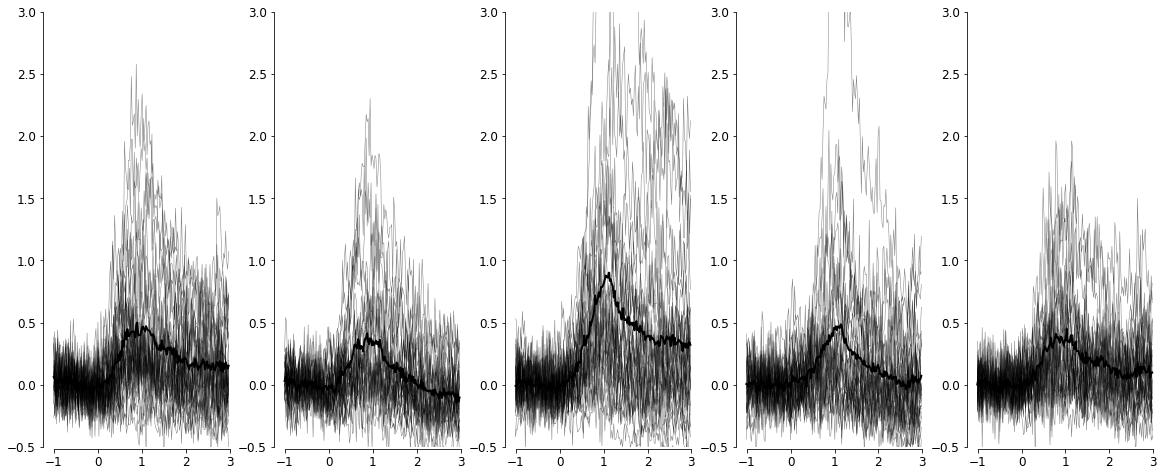

In [349]:
fig = pl.figure(figsize=(20,8))
currax = fig.add_subplot(111)
idx = 1
for morphname in dff.keys():
    pl.subplot(1,5,idx)
    for i in range(dff[morphname]['tsec'].shape[0]):
        pl.plot(dff[morphname]['tsec'][i,:], dff[morphname]['df'][i,:], 'k', linewidth=0.5, alpha=0.5)
    
    pl.plot(dff[morphname]['tsec'][i,:], np.mean(dff[morphname]['df'], axis=0), 'k', linewidth=2, alpha=1)
    curr_ntrials = dff[morphname]['df'].shape[0]
    print curr_ntrials
    currax.annotate("n = %i" % curr_ntrials, xy=psth.get_axis_limits(currax, xscale=0.2, yscale=0.5))
    
    pl.ylim([-0.5, 3])
    sns.despine(offset=2, trim=True)
    idx += 1

In [322]:
from scipy import stats

zscores = {}
for mkey in sorted(dff.keys(), key=natural_keys):
    mean_on = np.array([np.mean(dff[mkey]['df'][t, first_on:first_on+nframes_on]) for t in range(dff[mkey]['df'].shape[0])])
    std_baseline = np.array([np.std(dff[mkey]['df'][t, 0:first_on]) for t in range(dff[mkey]['df'].shape[0])])
    trial_zscore = mean_on / std_baseline
    zscores[mkey] = trial_zscore

mean_zscores = [np.mean(zscores[mkey]) for mkey in sorted(zscores.keys(), key=natural_keys)]
sem_yerr = [stats.sem(zscores[mkey]) for mkey in sorted(zscores.keys(), key=natural_keys)]


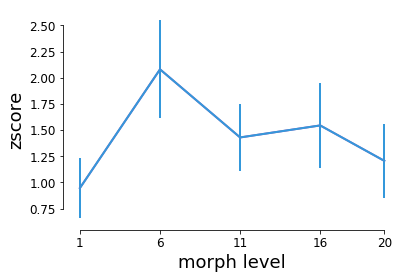

In [323]:

pl.figure()
pl.xticks(morphlevel_list, morphlevel_list)
pl.ylabel('zscore', fontsize=18)
pl.xlabel('morph level', fontsize=18)
pl.rcParams.update({'font.size': 12})

pl.plot(morphlevel_list, mean_zscores, linewidth=2)
pl.errorbar(morphlevel_list, mean_zscores, yerr=sem_yerr, linewidth=2)
sns.despine(offset=2, trim=True)

In [324]:
zscores[mkey]

array([ 3.68259169,  1.42558214,  2.50502881,  2.97179431,  0.56165459,
        1.30483132, -1.10118414,  4.14330677, -0.75688084,  0.53839278,
        0.64967547, -0.38794796, -0.4774243 ,  3.95775751,  0.17237899,
        0.4373517 ,  0.68631264,  4.44385443,  0.60285544, -1.56752129,
        5.55323573,  1.89536583,  0.19097707, -0.26159004,  0.19572414,
        0.91592029,  0.28195782])

In [325]:
sorted_trial_idxs = np.argsort(zscores[mkey])
print sorted_trial_idxs


[19  6  8 12 11 23 14 22 24 26 15  9  4 18 10 16 25  5  1 21  2  3  0 13
  7 17 20]


In [331]:
unsorted_df_traces = [dff[mkey]['df'][t,:] for t in range(dff[mkey]['df'].shape[0])]
sorted_df_traces = [dff[mkey]['df'][t,:] for t in sorted_trial_idxs]

In [332]:
sorted_df_traces = np.array(sorted_df_traces)
print sorted_df_traces.shape

(27, 179)


In [447]:
s_list = []
for t in sorted_trial_idxs:
    s = pd.Series(dff[mkey]['df'][t,:], index=[round(v, 2) for v in dff[mkey]['tsec'][t,:]], name=t)
    s_list.append(s)
dff_by_trials = pd.concat(s_list, axis=1)

In [448]:
dff_by_trials

,19,6,8,12,11,23,14,22,24,26,...,5,1,21,2,3,0,13,7,17,20
-1.01,-0.067120,-0.009233,0.276977,-0.073110,-0.012647,-0.114919,-0.083306,0.222596,-0.130989,0.064566,...,0.008064,0.265021,0.182051,-0.106417,-0.062132,-0.019301,0.243475,0.022627,0.136483,0.095367
-0.98,-0.155135,0.020411,0.541134,-0.036026,0.169422,-0.131689,0.208650,0.186787,-0.001837,0.128990,...,-0.072892,0.295584,0.105151,-0.162259,-0.054391,0.172955,0.012457,0.274670,0.248670,-0.001975
-0.96,-0.101929,0.005181,0.506525,0.161871,0.237152,-0.010783,0.097690,0.010181,0.034785,0.127146,...,0.036375,0.210504,-0.040527,-0.263713,0.129855,0.002239,0.167084,0.304047,-0.089239,0.056628
-0.94,-0.153877,0.153135,0.166124,-0.343133,-0.061464,-0.056733,-0.000600,0.078743,-0.044204,0.151394,...,0.000845,0.259435,-0.146772,-0.009894,0.004973,0.097080,0.163566,-0.297429,0.177081,-0.119901
-0.92,0.100763,0.107690,0.165175,-0.143114,-0.029085,0.145484,-0.287615,0.323333,-0.058793,0.120109,...,0.153964,0.266159,-0.171258,-0.093989,-0.166296,-0.045559,0.099591,0.151059,0.113238,-0.194207
-0.90,-0.063213,0.113747,0.212525,-0.186264,-0.012850,-0.106564,-0.158116,0.146269,-0.247540,0.194083,...,0.025125,0.202251,0.131642,-0.019305,-0.069792,-0.080666,-0.059039,-0.034933,0.120880,0.088887
-0.87,0.056313,-0.124045,0.367104,0.280176,0.096178,0.009847,-0.093572,0.328834,-0.042331,0.225776,...,0.013528,0.293525,0.057848,0.014907,0.021660,0.197600,-0.091393,0.206803,-0.262247,-0.280583
-0.85,0.079394,-0.038777,0.171165,-0.350921,-0.080417,0.120772,-0.185430,0.060576,0.190062,0.160517,...,0.137509,0.210214,-0.117640,0.001577,0.138885,-0.064888,-0.208512,0.169768,-0.036804,-0.255659
-0.83,-0.011122,-0.061447,0.159462,-0.146325,0.021022,-0.139105,0.289329,0.174694,0.082148,-0.085020,...,0.060944,0.177040,0.004574,-0.077148,0.006531,0.127673,0.155386,-0.208918,0.102011,0.010068
-0.81,-0.177792,-0.056927,0.166075,0.169506,0.021644,-0.094531,0.191334,0.251094,0.108743,0.212120,...,0.410298,-0.036885,-0.096485,0.015407,-0.246372,0.067819,-0.001149,-0.173061,0.211985,-0.095065


In [449]:
xticks = dff_by_trials.index
rounded = list(set([round(x) for x in xticks]))
print rounded
sec_idxs = [[abs(x-tsecval) for x in xticks].index(np.min([abs(x-tsecval) for x in xticks])) for tsecval in rounded]
sec_idxs = sorted(sec_idxs)
#stimon_idx = [abs(x-0) for x in xticks].index(np.min([abs(x-0) for x in xticks]))
#stimoff_idx = [abs(x-1.0) for x in xticks].index(np.min([abs(x-1.0) for x in xticks]))

#print xticks[sec_idxs]
#print xticks[stimoff_idx]

[-0.0, 1.0, 2.0, 3.0, -1.0]


In [450]:
# Create xtick labels for trial epochs:

xticklabels = ['' for i in range(len(xticks))]
for s in sec_idxs:
    xticklabels[s] = '{0:.2}'.format(round(xticks[s]))


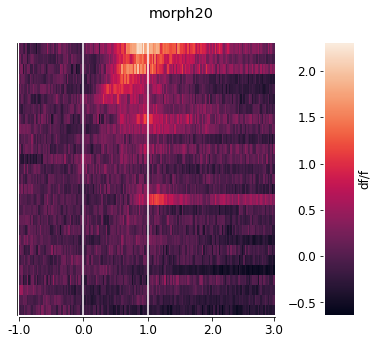

In [463]:
# Plot trials as heatmap:
import matplotlib.ticker as ticker
tsec_labels = [round(xticks[i]) for i in sec_idxs] #rounded[sec_idxs]

grid_kws = {"width_ratios": (.9, .1), "wspace": .35}
f, (ax, cbar_ax) = pl.subplots(ncols=2, gridspec_kw=grid_kws, figsize=(6,5))
pl.suptitle(mkey)
ax = sns.heatmap(dff_by_trials.T, ax=ax, xticklabels=False, yticklabels=False,
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "vertical","label": "df/f"})
ax.invert_yaxis()
sns.despine(trim=True, offset=2)

# Set x-tick labels to trial epochs:
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%i'))
ax.xaxis.set_major_locator(ticker.FixedLocator(sec_idxs)) #(base=1.0))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((tsec_labels)))

# Add vertical lines showing stim on/off:
ax.vlines([sec_idxs[1:3]], *ax.get_xlim(),  colors='w')

In [132]:
mlevel = 1
morphname = 'morph%02d' % mlevel
curr_morphs = roidata[roidata['morphlevel'] == mlevel]
dfmat = curr_morphs.groupby(['trial'])['df']
dfmat.shape

AttributeError: Cannot access attribute 'shape' of 'SeriesGroupBy' objects, try using the 'apply' method

In [98]:
zscores = pd.DataFrame()
morphlevels = sorted(list(set(roidata['morphlevel'])))
for mlevel in morphlevels:
    morphname = 'morph%02d' % mlevel
    trial_zscores = roidata[roidata['morphlevel']==mlevel]['zscore']
    zscores[morphname] = trial_zscores

In [111]:
zscores.mean()
zscores.sem()

morph01    0.300295
morph06    0.597732
morph11    0.523825
morph16    0.676872
morph20    0.471088
dtype: float64

<Container object of 3 artists>

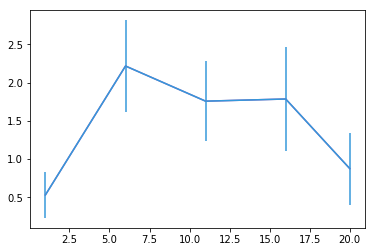

In [113]:
#for morph in zscores.keys():
pl.plot(morphlevels, zscores.mean())
pl.errorbar(morphlevels, zscores.mean(), yerr=zscores.sem())

In [114]:
zscores.count()

morph01    11
morph06    15
morph11    14
morph16    13
morph20    14
dtype: int64